In [1]:
import numpy as np
import pandas as pd 
from scipy import stats
import warnings


import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_validate



import matplotlib.pyplot as plt
import seaborn as sns

import time
start_time = time.time()
%matplotlib inline

In [2]:
# Import the housing dataset as a Pandas Dataframe
df = pd.read_csv('data/kc_house_data.csv')
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [3]:
# Create a summmary of each column in the df
print(df.info())

print('''
yr_renovated and waterfront are only columns containing null values
''')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

In [4]:
# Set Nan values of 'waterfront' and 'year_renovated' columns to 0
df.loc[df.waterfront.isna()==True, 'waterfront'] = 0
df.loc[df.yr_renovated.isna()==True, 'yr_renovated'] = 0

#Set all sqft_basement values of '?' to 0, then convert to floats.
df.loc[df.sqft_basement=='?', 'sqft_basement'] = 0
df.sqft_basement = df.sqft_basement.astype(float)

# Convert 'date' to a datetime object and use these to create a 'year' column
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].apply(lambda date: date.year)

# Create an 'age' column to specify how old a house was at sale
df['age'] = df['year'] - df['yr_built']

#Drop unnecessary 'id', 'yr_built', 'year', and 'date' columns
cols_to_drop = ['id', 'yr_built', 'year', 'date']
df.drop(cols_to_drop, axis=1, inplace=True)

#Drop rows that contain null values in the 'view' column
df.dropna(subset = ['view'], inplace = True)

## Handling Outliers

In [5]:
target_cols = ['bathrooms', 'bedrooms', 'sqft_living']

outlier_cols = ['outlier_' + col for col in target_cols]
z_scores = [stats.zscore(df[col]) 
                for col in target_cols]

for outlier_col, z_score in zip(outlier_cols, z_scores):
    df[outlier_col] = ((z_score > 3) | (z_score <-3))

query_empty = '({} == False)&'*(len(target_cols))
query = query_empty[:-1].format(*outlier_cols)
df = df.query(query)


df = df.drop(columns=outlier_cols)

# Drop the outlier house that contains 33 bedrooms
df = df[df['bedrooms'] != 33]

# Drop houses that were bought before construction
df = df[df['age'] != -1]

There is a relatively normal distribution of bedroom sizes


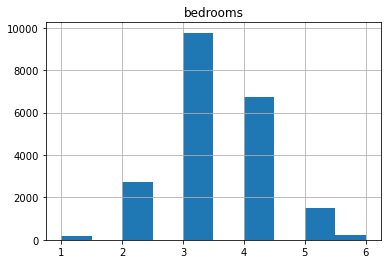

In [6]:
df.hist('bedrooms');
print('There is a relatively normal distribution of bedroom sizes')

Price has a positive skew


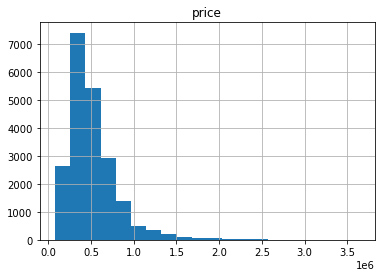

In [7]:
print("Price has a positive skew")
df.hist('price', bins=20);

In [8]:
# Create a matrix of correlations for each feature set in the dataframe
corr_matrix = df.corr()
# Create a boolean mask for all values on or above the matrix diagonal 
corr_matrix_mask = np.triu(np.ones_like(df.corr(), dtype=bool));

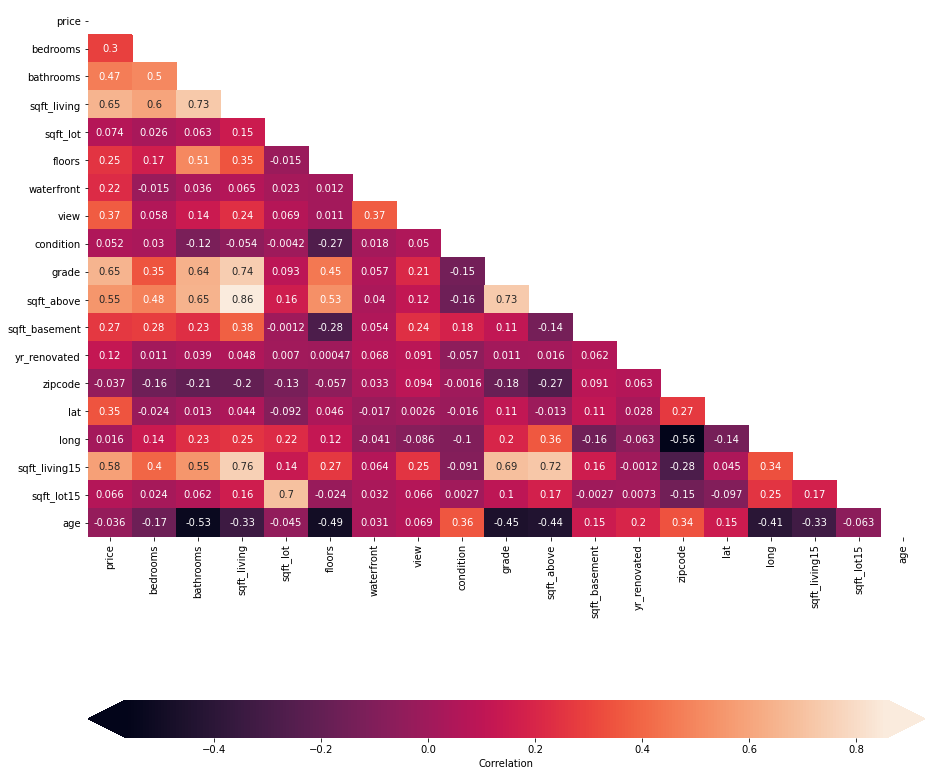

In [9]:
# Creates a heat map of correlation coefficient
fig, ax = plt.subplots(figsize  =(15,15))
sns.heatmap(
            corr_matrix, 
            ax=ax, 
            annot=True, 
            mask= corr_matrix_mask,
            cbar_kws={"label": "Correlation", "orientation": "horizontal", "pad": .2, "extend": "both"}
);

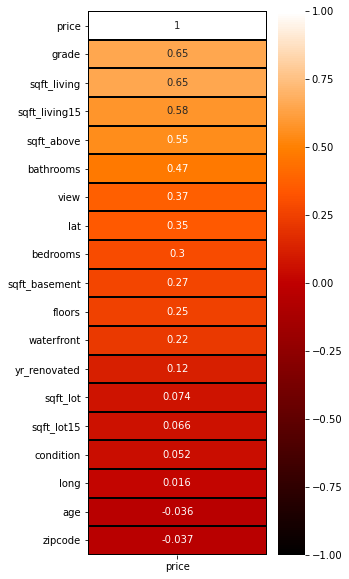

In [10]:
# Price will be our target value to predict, so we'll zero in on its correlations.
plt.figure(figsize=(4,10))
heatmap = sns.heatmap(df.corr()[['price']].sort_values(by='price', ascending=False), vmin=-1, vmax=1, linewidths=1, linecolor='black', annot=True, fmt='.2g', cmap="gist_heat")

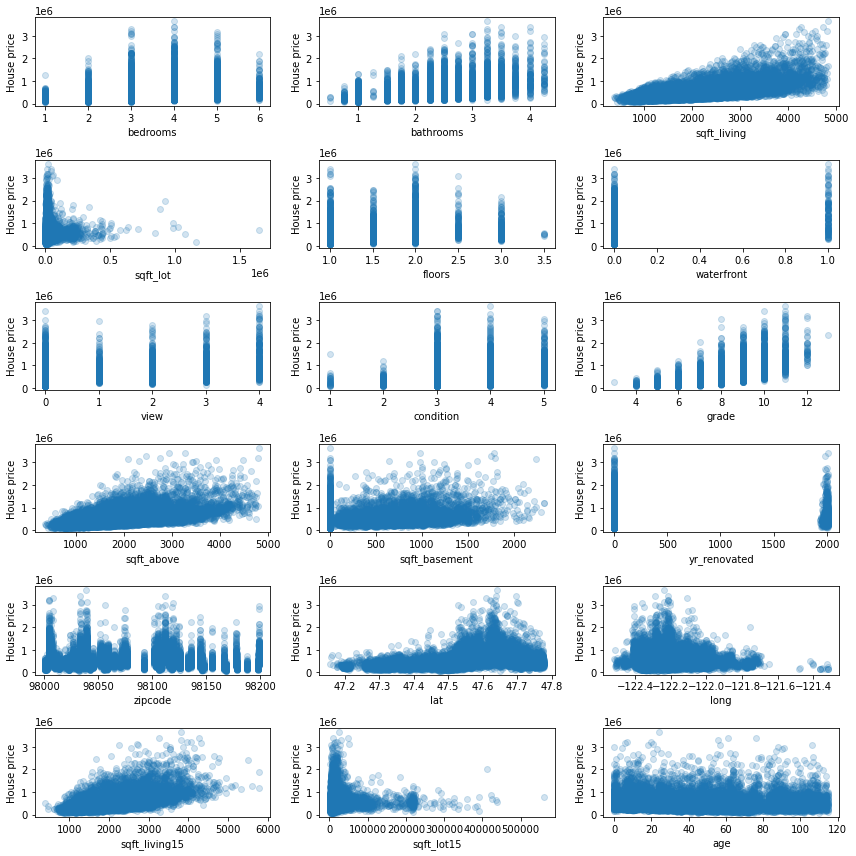

In [11]:
x = df.drop('price', axis=1)
y= df.price
fig, axes = plt.subplots(ncols=3, nrows=6, figsize=(12, 12))
fig.set_tight_layout(True)
for index, col in enumerate(x.columns): 
    ax = axes[index//3][index%3]
    ax.scatter(x[col], y, alpha=0.2)
    ax.set_xlabel(col)
    ax.set_ylabel("House price")

# Model Building

## Baseline Model

In [12]:
# Drop the new 'age' column and our target column 'price' for the indep. features
X = df.drop(['price', 'age'], axis = 1)

# Set our dependent variable as price
y = df.price
  
# Split up our independent and dependent variables into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
# Trains our model on our baseline values
lm = LinearRegression().fit(X_train, y_train)

lm_dummy_mean = DummyRegressor(strategy = 'mean').fit(X_train, y_train)

y_predict = lm.predict(X_test)
y_predict_dummy_mean = lm_dummy_mean.predict(X_test)

print(r2_score(y_test, y_predict))

0.6727487781095965


### Model 1:  including 'age'

In [14]:
# Drop the dependent variable from the independent columns
X = df.drop(['price'], axis = 1)

# Set our dependent variable as price
y = df['price']

# Split up our independent and dependent variables into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
# Initialize an empty regression model
lr = LinearRegression()

# Fits the model to our training dataset
lr.fit(X_train, y_train)

pred_lr1 = lr.predict(X_test)

train_score_lr1 = lr.score(X_train, y_train)
test_score_lr1 = lr.score(X_test, y_test)

In [16]:
lr.coef_[0]

-24532.17163643667

In [17]:
lr.intercept_

-2160858.774951554

In [18]:
rmse_lr1 = mean_squared_error(y_test, pred_lr1, squared=False)

In [19]:
train_score_lr1, test_score_lr1, rmse_lr1 #(0.7026591179673133, 0.6931727130407752, 205731.06771444588)

(0.691458718475255, 0.6885558723559433, 168660.86272805923)

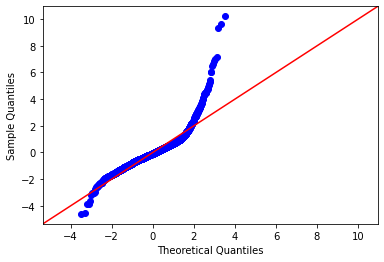

In [20]:
# Checking the QQ Plot
residuals1 = (y_test - pred_lr1)
sm.graphics.qqplot(residuals1, dist=stats.norm, line="45", fit=True);

Text(0, 0.5, 'Actual - Predicted Value')

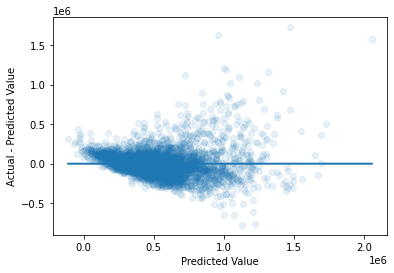

In [21]:
residuals1 = (y_test - pred_lr1)
fig, ax = plt.subplots()
ax.scatter(pred_lr1, residuals1, alpha=.1)
ax.plot(pred_lr1, [0 for i in range(len(X_test))])
ax.set_xlabel('Predicted Value')
ax.set_ylabel('Actual - Predicted Value')

<AxesSubplot:xlabel='price'>

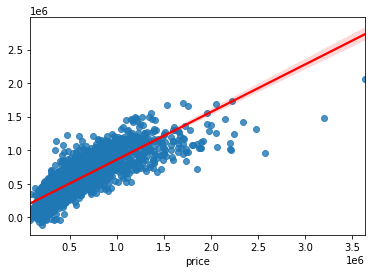

In [22]:
sns.regplot(x = y_test, y = pred_lr1, data = df, line_kws={'color':'r'})

### Model 2: log transform 'price'

In [23]:
# Drop the dependent variable from the independent columns
X = df.drop(['price'], axis = 1)

# Set our dependent variable as the natural log of price
y = np.log(df['price'])

# Split up our independent and dependent variables into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:
# Initialize an empty regression model
lr = LinearRegression()

# Fits the model to our training dataset
lr.fit(X_train, y_train)

pred_lr2 = lr.predict(X_test)

In [25]:
train_score_lr2 = lr.score(X_train, y_train)
test_score_lr2 = lr.score(X_test, y_test)

In [26]:
lr.coef_[0] 

-0.01798952328000877

In [27]:
lr.intercept_

-13.94477759739004

In [28]:
rmse_lr2 = mean_squared_error(y_test, pred_lr2, squared=False)

In [29]:
train_score_lr2, test_score_lr2, rmse_lr2 # (0.7716633054371127, 0.7649036245277617, 0.25717593403330175)

(0.7558928001010051, 0.7516799842033415, 0.25081527669729825)

### Checking the VIF Score

In [30]:
# Making a constant column
df_temp = sm.add_constant(df)

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(df_temp.values, i) for i in range(df_temp.values.shape[1])]
vif["features"] = df_temp.columns

print(vif.round(1))

    VIF Factor       features
0    4439044.0          const
1          3.2          price
2          1.7       bedrooms
3          3.2      bathrooms
4        131.9    sqft_living
5          2.0       sqft_lot
6          2.1         floors
7          1.2     waterfront
8          1.4           view
9          1.3      condition
10         3.6          grade
11       113.7     sqft_above
12        34.4  sqft_basement
13         1.1   yr_renovated
14         1.7        zipcode
15         1.4            lat
16         1.8           long
17         3.0  sqft_living15
18         2.0     sqft_lot15
19         2.6            age


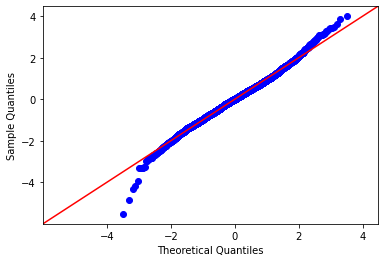

In [31]:
# Making the QQ Plot
residuals2 = (y_test - pred_lr2)
sm.graphics.qqplot(residuals2, dist=stats.norm, line="45", fit=True);

Text(0, 0.5, 'Actual - Predicted Value')

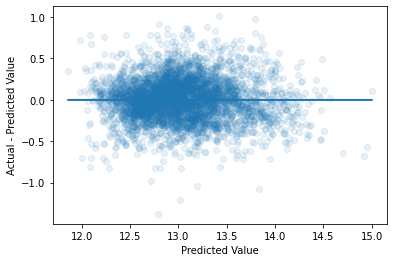

In [32]:
residuals2 = (y_test - pred_lr2)
fig, ax = plt.subplots()
ax.scatter(pred_lr2, residuals2, alpha=.1)
ax.plot(pred_lr2, [0 for i in range(len(X_test))])
ax.set_xlabel('Predicted Value')
ax.set_ylabel('Actual - Predicted Value')

<AxesSubplot:xlabel='price'>

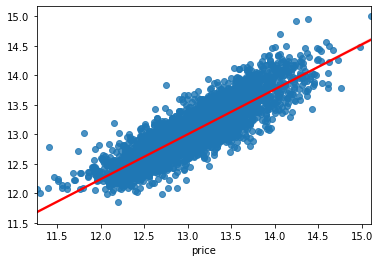

In [33]:
sns.regplot(x = y_test, y = pred_lr2, data = df, line_kws={'color':'r'})

### Model 3:  creating dummy columns for zip code

In [34]:
# Adds dummy zipcode columns
df = df.join(pd.get_dummies(df['zipcode'], prefix = 'x', drop_first = True))

In [35]:
# Drop the dependent variable from the independent columns
X = df.drop(['price'], axis = 1)

# Set our dependent variable as the natural log of price
y = np.log(df['price'])

# Split up our independent and dependent variables into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [36]:
# Initialize an empty regression model
lr = LinearRegression()

# Fits the model to our training dataset
lr.fit(X_train, y_train)

LinearRegression()

In [37]:
pred_lr3 = lr.predict(X_test)

In [38]:
train_score_lr3 = lr.score(X_train, y_train)
test_score_lr3 = lr.score(X_test, y_test)

In [39]:
lr.coef_[0]

0.0001405671838812507

In [40]:
lr.intercept_

-347.44107328808855

In [41]:
rmse_lr3 = mean_squared_error(y_test, pred_lr3, squared=False)

In [42]:
train_score_lr3, test_score_lr3, rmse_lr3 # (0.8783623094453447, 0.8702059345827169, 0.19108859922879654)

(0.8707370644231542, 0.8703464138146122, 0.18123429732392743)

In [43]:
# Making an OLS table to check for significance
X = sm.add_constant(X)
sm.OLS(y, X).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.871
Model:                            OLS   Adj. R-squared:                  0.870
Method:                 Least Squares   F-statistic:                     1649.
Date:                Wed, 14 Jul 2021   Prob (F-statistic):               0.00
Time:                        12:51:44   Log-Likelihood:                 6120.4
No. Observations:               21132   AIC:                        -1.207e+04
Df Residuals:                   21045   BIC:                        -1.137e+04
Df Model:                          86                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0229      0.001    -21.172      0.000      -0.025      -0.021
bedrooms       4.294e-06      0.002      0.002      0.998      -0.004       0.004
bathrooms         0.0478      0.003     15.198      0.000       0.042       0.054
sqft_living       0.0001   1.77e-05      8.016      0.000       0.000       0.000
sqft_lot       5.927e-07   4.42e-08     13.402      0.000    5.06e-07    6.79e-07
floors           -0.0360      0.004     -9.838      0.000      -0.043      -0.029
waterfront        0.4716      0.018     26.078      0.000       0.436       0.507
view              0.0629      0.002     30.904      0.000       0.059       0.067
condition         0.0546      0.002     24.915      0.000       0.050       0.059
grade             0.0887      0.002     42.114      0.000       0.085       0.093
sqft_above     8.245e-05   1.77e-05      4.650      0.000    4.77e-05       0.000
sqft_basement  2.342e-06   1.76e-05      0.133      0.894   -3.21e-05    3.67e-05
yr_renovated   3.557e-05   3.67e-06      9.681      0.000    2.84e-05    4.28e-05
zipcode          -0.0006   7.17e-05     -8.257      0.000      -0.001      -0.000
lat               0.5101      0.072      7.044      0.000       0.368       0.652
long             -0.3677      0.052     -7.057      0.000      -0.470      -0.266
sqft_living15  7.429e-05   3.45e-06     21.554      0.000    6.75e-05     8.1e-05
sqft_lot15     2.255e-07   7.23e-08      3.120      0.002    8.39e-08    3.67e-07
age               0.0005   7.38e-05      7.399      0.000       0.000       0.001
x_98002          -0.0111      0.016     -0.673      0.501      -0.043       0.021
x_98003          -0.0038      0.015     -0.258      0.797      -0.033       0.025
x_98004           0.9520      0.027     35.409      0.000       0.899       1.005
x_98005           0.6079      0.029     21.255      0.000       0.552       0.664
x_98006           0.5384      0.023     22.917      0.000       0.492       0.584
x_98007           0.5366      0.030     18.150      0.000       0.479       0.595
x_98008           0.5402      0.028     19.262      0.000       0.485       0.595
x_98010           0.3303      0.025     13.000      0.000       0.280       0.380
x_98011           0.2455      0.036      6.756      0.000       0.174       0.317
x_98014           0.2725      0.040      6.734      0.000       0.193       0.352
x_98019           0.2305      0.040      5.818      0.000       0.153       0.308
x_98022           0.1904      0.023      8.309      0.000       0.145       0.235
x_98023          -0.0588      0.013     -4.478      0.000      -0.084      -0.033
x_98024           0.4281      0.036     11.866      0.000       0.357       0.499
x_98027           0.4848      0.024     19.872      0.000       0.437       0.533
x_98028           0.2116      0.035      6.072   

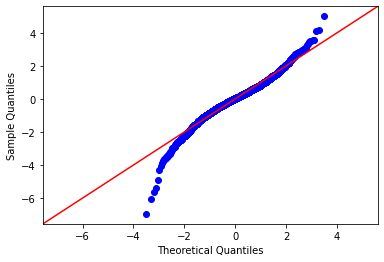

In [44]:
# Making the QQ Plot
residuals3 = (y_test - pred_lr3)
sm.graphics.qqplot(residuals3, dist=stats.norm, line="45", fit=True);

Text(0, 0.5, 'Actual - Predicted Value')

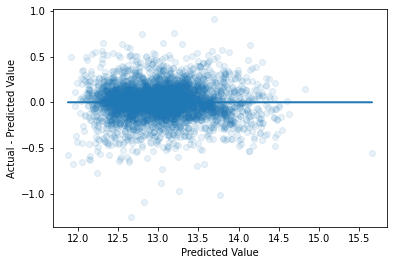

In [45]:
residuals3 = (y_test - pred_lr3)
fig, ax = plt.subplots()
ax.scatter(pred_lr3, residuals3, alpha=.1)
ax.plot(pred_lr3, [0 for i in range(len(X_test))])
ax.set_xlabel('Predicted Value')
ax.set_ylabel('Actual - Predicted Value')

<AxesSubplot:xlabel='price'>

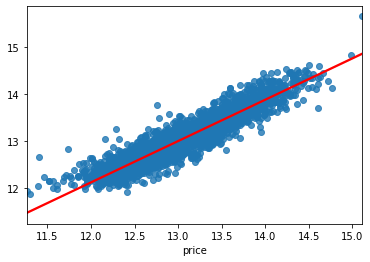

In [46]:
sns.regplot(x = y_test, y = pred_lr3, data = df, line_kws={'color':'r'})

### Model 4:  dropping features with high p_values


In [47]:
# Use summary above to drop features with high p_values
X = df.drop(['price', 'x_98002', 'x_98003', 'sqft_basement', 'sqft_lot15'], axis = 1)

# Set our dependent variable as the natural log of price
y = np.log(df['price'])

# Split up our independent and dependent variables into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [48]:
# Initialize an empty regression model
lr = LinearRegression()

# Fits the model to our training dataset
lr.fit(X_train, y_train)

LinearRegression()

In [49]:
pred_lr4 = lr.predict(X_test)

In [50]:
train_score_lr4 = lr.score(X_train, y_train)
test_score_lr4 = lr.score(X_test, y_test)

In [51]:
lr.coef_[0]

-2.768161023620743e-05

In [52]:
lr.intercept_

146.7446789003085

In [53]:
rmse_lr4 = mean_squared_error(y_test, pred_lr4, squared=False)

In [54]:
train_score_lr4, test_score_lr4, rmse_lr4 # (0.8783495053881852, 0.8702421515098159, 0.19106193728286688)

(0.8706874761365908, 0.8702492125379794, 0.18130222026037732)

In [55]:
# Checking the OLS for values of significance
X = sm.add_constant(X)
sm.OLS(y, X).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.871
Model:                            OLS   Adj. R-squared:                  0.870
Method:                 Least Squares   F-statistic:                     1708.
Date:                Wed, 14 Jul 2021   Prob (F-statistic):               0.00
Time:                        12:51:46   Log-Likelihood:                 6115.3
No. Observations:               21132   AIC:                        -1.206e+04
Df Residuals:                   21048   BIC:                        -1.139e+04
Df Model:                          83                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           213.6954    715.593      0.299      0.765   -1188.922    1616.313
bedrooms         -0.0002      0.002     -0.106      0.915      -0.004       0.004
bathrooms         0.0475      0.003     15.120      0.000       0.041       0.054
sqft_living       0.0001   4.35e-06     33.346      0.000       0.000       0.000
sqft_lot       6.804e-07   3.43e-08     19.850      0.000    6.13e-07    7.48e-07
floors           -0.0364      0.004     -9.946      0.000      -0.044      -0.029
waterfront        0.4714      0.018     26.066      0.000       0.436       0.507
view              0.0629      0.002     30.891      0.000       0.059       0.067
condition         0.0547      0.002     24.949      0.000       0.050       0.059
grade             0.0887      0.002     42.134      0.000       0.085       0.093
sqft_above     8.019e-05   4.34e-06     18.493      0.000    7.17e-05    8.87e-05
yr_renovated   3.564e-05   3.67e-06      9.697      0.000    2.84e-05    4.28e-05
zipcode          -0.0028      0.007     -0.379      0.705      -0.017       0.012
lat               0.5108      0.072      7.054      0.000       0.369       0.653
long             -0.3660      0.050     -7.284      0.000      -0.464      -0.268
sqft_living15  7.499e-05   3.44e-06     21.805      0.000    6.83e-05    8.17e-05
age               0.0005   7.38e-05      7.404      0.000       0.000       0.001
x_98004           0.9599      0.030     32.075      0.000       0.901       1.019
x_98005           0.6185      0.036     17.328      0.000       0.549       0.688
x_98006           0.5503      0.037     14.686      0.000       0.477       0.624
x_98007           0.5509      0.047     11.697      0.000       0.459       0.643
x_98008           0.5567      0.052     10.630      0.000       0.454       0.659
x_98010           0.3557      0.065      5.456      0.000       0.228       0.484
x_98011           0.2684      0.075      3.570      0.000       0.121       0.416
x_98014           0.3075      0.098      3.125      0.002       0.115       0.500
x_98019           0.2741      0.132      2.078      0.038       0.016       0.533
x_98022           0.2414      0.150      1.610      0.108      -0.053       0.535
x_98023          -0.0089      0.154     -0.058      0.954      -0.311       0.293
x_98024           0.4861      0.167      2.914      0.004       0.159       0.813
x_98027           0.5447      0.186      2.932      0.003       0.181       0.909
x_98028           0.2718      0.193      1.406      0.160      -0.107       0.651
x_98029           0.6411      0.201      3.191      0.001       0.247       1.035
x_98030           0.1320      0.206      0.640      0.522      -0.272       0.536
x_98031           0.1398      0.214      0.655      0.513      -0.279       0.558
x_98032           0.0162      0.221      0.073   

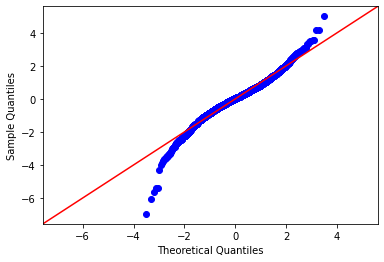

In [56]:
# Making the QQ Plot
residuals4 = (y_test - pred_lr4)
sm.graphics.qqplot(residuals4, dist=stats.norm, line="45", fit=True);

Text(0, 0.5, 'Actual - Predicted Value')

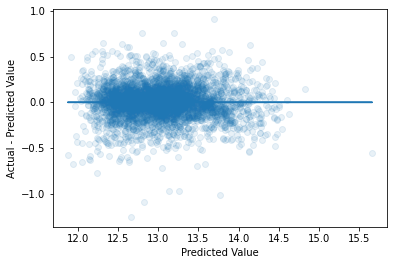

In [57]:
residuals4 = (y_test - pred_lr4)
fig, ax = plt.subplots()
ax.scatter(pred_lr4, residuals4, alpha=.1)
ax.plot(pred_lr4, [0 for i in range(len(X_test))])
ax.set_xlabel('Predicted Value')
ax.set_ylabel('Actual - Predicted Value')

<AxesSubplot:xlabel='price'>

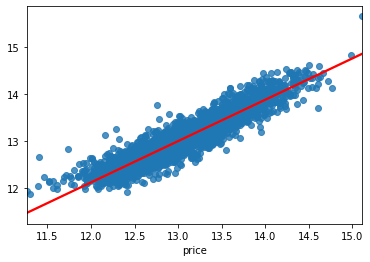

In [58]:
sns.regplot(x = y_test, y = pred_lr4, data = df, line_kws={'color':'r'})

### Model 5: adding back the zipcodes we dropped in our previous model

In [59]:
X = df.drop(['price', 'sqft_basement', 'sqft_lot15'], axis = 1)
y = df['price'] 
y = np.log(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [60]:
# Initialize an empty regression model
lr = LinearRegression()

# Fits the model to our training dataset
lr.fit(X_train, y_train)

LinearRegression()

In [61]:
pred_lr5 = lr.predict(X_test)

In [62]:
train_score_lr5 = lr.score(X_train, y_train)
test_score_lr5 = lr.score(X_test, y_test)

In [63]:
lr.coef_[0]

-2.729922912770856e-05

In [64]:
lr.intercept_

-345.9616598640733

In [65]:
rmse_lr5 = mean_squared_error(y_test, pred_lr5, squared=False)

In [66]:
train_score_lr5, test_score_lr5, rmse_lr5

(0.8706920978205415, 0.870242721794235, 0.18130675499792417)

In [67]:
# Checking the OLS for values of significance
X = sm.add_constant(X)
sm.OLS(y, X).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.871
Model:                            OLS   Adj. R-squared:                  0.870
Method:                 Least Squares   F-statistic:                     1688.
Date:                Wed, 14 Jul 2021   Prob (F-statistic):               0.00
Time:                        12:51:51   Log-Likelihood:                 6115.5
No. Observations:               21132   AIC:                        -1.206e+04
Df Residuals:                   21047   BIC:                        -1.138e+04
Df Model:                          84                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0228      0.001    -21.093      0.000      -0.025      -0.021
bedrooms         -0.0002      0.002     -0.104      0.917      -0.004       0.004
bathrooms         0.0475      0.003     15.122      0.000       0.041       0.054
sqft_living       0.0001   4.35e-06     33.345      0.000       0.000       0.000
sqft_lot       6.798e-07   3.43e-08     19.827      0.000    6.13e-07    7.47e-07
floors           -0.0364      0.004     -9.932      0.000      -0.044      -0.029
waterfront        0.4715      0.018     26.069      0.000       0.436       0.507
view              0.0629      0.002     30.894      0.000       0.059       0.067
condition         0.0547      0.002     24.954      0.000       0.050       0.059
grade             0.0887      0.002     42.093      0.000       0.085       0.093
sqft_above     8.023e-05   4.34e-06     18.501      0.000    7.17e-05    8.87e-05
yr_renovated   3.565e-05   3.68e-06      9.699      0.000    2.84e-05    4.28e-05
zipcode          -0.0006   7.16e-05     -8.093      0.000      -0.001      -0.000
lat               0.5110      0.072      7.056      0.000       0.369       0.653
long             -0.3573      0.052     -6.870      0.000      -0.459      -0.255
sqft_living15  7.492e-05   3.44e-06     21.772      0.000    6.82e-05    8.17e-05
age               0.0005   7.39e-05      7.411      0.000       0.000       0.001
x_98002          -0.0118      0.016     -0.717      0.474      -0.044       0.020
x_98003          -0.0035      0.015     -0.236      0.814      -0.032       0.025
x_98004           0.9508      0.027     35.361      0.000       0.898       1.004
x_98005           0.6069      0.029     21.219      0.000       0.551       0.663
x_98006           0.5363      0.023     22.837      0.000       0.490       0.582
x_98007           0.5346      0.030     18.087      0.000       0.477       0.593
x_98008           0.5380      0.028     19.186      0.000       0.483       0.593
x_98010           0.3317      0.025     13.056      0.000       0.282       0.381
x_98011           0.2439      0.036      6.710      0.000       0.173       0.315
x_98014           0.2734      0.040      6.754      0.000       0.194       0.353
x_98019           0.2299      0.040      5.803      0.000       0.152       0.308
x_98022           0.1911      0.023      8.340      0.000       0.146       0.236
x_98023          -0.0582      0.013     -4.433      0.000      -0.084      -0.032
x_98024           0.4305      0.036     11.935      0.000       0.360       0.501
x_98027           0.4838      0.024     19.832      0.000       0.436       0.532
x_98028           0.2104      0.035      6.035      0.000       0.142       0.279
x_98029           0.5754      0.028     20.661      0.000       0.521       0.630
x_98030           0.0658      0.016      3.989   

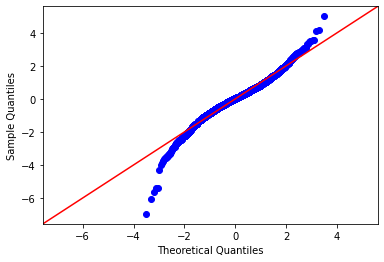

In [68]:
residuals5 = (y_test - pred_lr5)
sm.graphics.qqplot(residuals5, dist=stats.norm, line="45", fit=True);

Text(0, 0.5, 'Actual - Predicted Value')

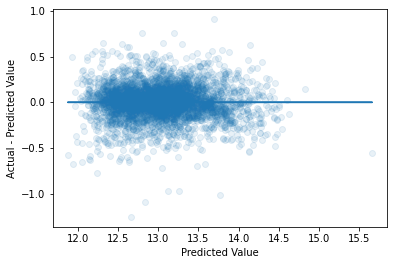

In [69]:
residuals5 = (y_test - pred_lr4)
fig, ax = plt.subplots()
ax.scatter(pred_lr5, residuals5, alpha=.1)
ax.plot(pred_lr5, [0 for i in range(len(X_test))])
ax.set_xlabel('Predicted Value')
ax.set_ylabel('Actual - Predicted Value')

<AxesSubplot:xlabel='price'>

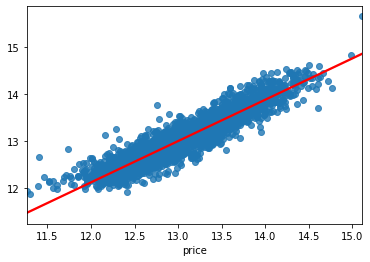

In [70]:
sns.regplot(x = y_test, y = pred_lr5, data = df, line_kws={'color':'r'})

### Model 6: Our best LR model

In [71]:
X = df.drop(['price', 'sqft_basement', 'sqft_lot15', 'sqft_above'], axis = 1)
y = df['price'] 
y = np.log(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [72]:
lr = LinearRegression()
lr.fit(X_train, y_train)
pred_lr6 = lr.predict(X_test)

train_score_lr6 = lr.score(X_train, y_train)
test_score_lr6 = lr.score(X_test, y_test)

lr.coef_[0]
lr.intercept_
rmse_lr6 = mean_squared_error(y_test, pred_lr6, squared=False)

In [73]:
train_score_lr6, test_score_lr6, rmse_lr6 #(0.8765432246064853, 0.8686285930439092, 0.19224620904784312)

(0.8685174872418951, 0.868428118543451, 0.18257010443077304)

In [74]:
X = sm.add_constant(X)
sm.OLS(y, X).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.869
Model:                            OLS   Adj. R-squared:                  0.868
Method:                 Least Squares   F-statistic:                     1677.
Date:                Wed, 14 Jul 2021   Prob (F-statistic):               0.00
Time:                        12:51:54   Log-Likelihood:                 5945.1
No. Observations:               21132   AIC:                        -1.172e+04
Df Residuals:                   21048   BIC:                        -1.105e+04
Df Model:                          83                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0219      0.001    -20.091      0.000      -0.024      -0.020
bedrooms         -0.0007      0.002     -0.380      0.704      -0.005       0.003
bathrooms         0.0384      0.003     12.273      0.000       0.032       0.045
sqft_living       0.0002   3.45e-06     56.486      0.000       0.000       0.000
sqft_lot       7.004e-07   3.45e-08     20.273      0.000    6.33e-07    7.68e-07
floors           -0.0026      0.003     -0.823      0.410      -0.009       0.004
waterfront        0.4748      0.018     26.039      0.000       0.439       0.511
view              0.0573      0.002     28.250      0.000       0.053       0.061
condition         0.0511      0.002     23.212      0.000       0.047       0.055
grade             0.0962      0.002     46.142      0.000       0.092       0.100
yr_renovated   3.441e-05    3.7e-06      9.290      0.000    2.72e-05    4.17e-05
zipcode          -0.0005   7.22e-05     -7.572      0.000      -0.001      -0.000
lat               0.5074      0.073      6.951      0.000       0.364       0.651
long             -0.3318      0.052     -6.331      0.000      -0.434      -0.229
sqft_living15  8.309e-05   3.44e-06     24.153      0.000    7.63e-05    8.98e-05
age               0.0007    7.4e-05      9.342      0.000       0.001       0.001
x_98002          -0.0086      0.017     -0.521      0.603      -0.041       0.024
x_98003          -0.0067      0.015     -0.452      0.651      -0.036       0.022
x_98004           0.9432      0.027     34.800      0.000       0.890       0.996
x_98005           0.5948      0.029     20.632      0.000       0.538       0.651
x_98006           0.5194      0.024     21.956      0.000       0.473       0.566
x_98007           0.5243      0.030     17.598      0.000       0.466       0.583
x_98008           0.5286      0.028     18.704      0.000       0.473       0.584
x_98010           0.3298      0.026     12.878      0.000       0.280       0.380
x_98011           0.2370      0.037      6.468      0.000       0.165       0.309
x_98014           0.2661      0.041      6.523      0.000       0.186       0.346
x_98019           0.2229      0.040      5.582      0.000       0.145       0.301
x_98022           0.1919      0.023      8.307      0.000       0.147       0.237
x_98023          -0.0620      0.013     -4.688      0.000      -0.088      -0.036
x_98024           0.4254      0.036     11.698      0.000       0.354       0.497
x_98027           0.4640      0.025     18.887      0.000       0.416       0.512
x_98028           0.2009      0.035      5.719      0.000       0.132       0.270
x_98029           0.5630      0.028     20.059      0.000       0.508       0.618
x_98030           0.0632      0.017      3.804      0.000       0.031       0.096
x_98031           0.0651      0.017      3.780   

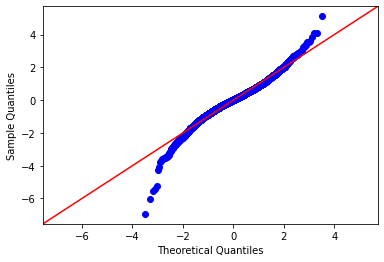

In [75]:
# Making the QQ Plot
residuals6 = (y_test - pred_lr6)
sm.graphics.qqplot(residuals6, dist=stats.norm, line="45", fit=True);

Text(0, 0.5, 'Actual - Predicted Value')

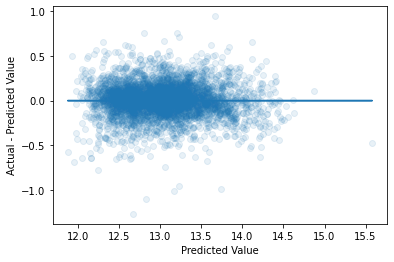

In [76]:
residuals6 = (y_test - pred_lr6)
fig, ax = plt.subplots()
ax.scatter(pred_lr6, residuals6, alpha=.1)
ax.plot(pred_lr6, [0 for i in range(len(X_test))])
ax.set_xlabel('Predicted Value')
ax.set_ylabel('Actual - Predicted Value')

<AxesSubplot:xlabel='price'>

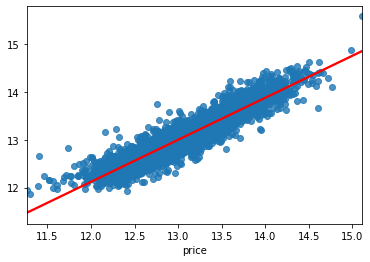

In [77]:
sns.regplot(x = y_test, y = pred_lr6, data = df, line_kws={'color':'r'})

### Model 7: Feature Engineering

In [78]:
# Feature Engineering Making 4 new colmns
df['grade_sqft_living'] = (df.grade**2) * df.sqft_living
df['grade_sqft_above'] = (df.grade**2) * df.sqft_above
df['grade_sqft_living15'] = (df.grade**2) * df.sqft_living15
df['grade_bathrooms'] = (df.grade**2) * df.bathrooms

In [79]:
# Droping columns that are not going to be used
X = df.drop(['price', 'sqft_basement', 'sqft_lot15', 'sqft_above', 'bathrooms', 'sqft_living', 'grade'], axis = 1)
y = df['price'] 
y = np.log(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [80]:
# Initialize an empty regression model
lr = LinearRegression()

# Fits the model to our training dataset
lr.fit(X_train, y_train)

LinearRegression()

In [81]:
pred_lr7 = lr.predict(X_test)

In [82]:
train_score_lr7 = lr.score(X_train, y_train)
test_score_lr7 = lr.score(X_test, y_test)

In [83]:
lr.coef_[0]

0.01866568006012778

In [84]:
lr.intercept_

-345.7780589843327

In [85]:
rmse_lr7 = mean_squared_error(y_test, pred_lr7, squared=False)

In [86]:
train_score_lr7, test_score_lr7, rmse_lr7 #(0.8571154620484464, 0.8450870182567047, 0.20876191193343574)

(0.8578204857065036, 0.8582847155867311, 0.1894769859945585)

In [87]:
# Checking OLS for values of significance
X = sm.add_constant(X)
sm.OLS(y, X).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.858
Method:                 Least Squares   F-statistic:                     1515.
Date:                Wed, 14 Jul 2021   Prob (F-statistic):               0.00
Time:                        12:51:57   Log-Likelihood:                 5127.3
No. Observations:               21132   AIC:                        -1.008e+04
Df Residuals:                   21047   BIC:                            -9408.
Df Model:                          84                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.0230      0.001    -20.352      0.000      -0.025      -0.021
bedrooms                0.0177      0.002      9.195      0.000       0.014       0.022
sqft_lot             6.525e-07   3.61e-08     18.087      0.000    5.82e-07    7.23e-07
floors                 -0.0138      0.004     -3.722      0.000      -0.021      -0.007
waterfront              0.4614      0.019     24.337      0.000       0.424       0.499
view                    0.0651      0.002     30.254      0.000       0.061       0.069
condition               0.0615      0.002     26.880      0.000       0.057       0.066
yr_renovated         4.802e-05   3.84e-06     12.507      0.000    4.05e-05    5.55e-05
zipcode                -0.0006    7.5e-05     -8.298      0.000      -0.001      -0.000
lat                     0.5372      0.076      7.079      0.000       0.388       0.686
long                   -0.3859      0.054     -7.082      0.000      -0.493      -0.279
sqft_living15           0.0003   6.16e-06     45.735      0.000       0.000       0.000
age                 -2.913e-05   7.48e-05     -0.390      0.697      -0.000       0.000
x_98002                -0.0183      0.017     -1.060      0.289      -0.052       0.016
x_98003                 0.0075      0.015      0.487      0.626      -0.023       0.038
x_98004                 0.9340      0.028     33.150      0.000       0.879       0.989
x_98005                 0.6263      0.030     20.904      0.000       0.568       0.685
x_98006                 0.5514      0.025     22.411      0.000       0.503       0.600
x_98007                 0.5474      0.031     17.680      0.000       0.487       0.608
x_98008                 0.5473      0.029     18.631      0.000       0.490       0.605
x_98010                 0.3229      0.027     12.128      0.000       0.271       0.375
x_98011                 0.2388      0.038      6.269      0.000       0.164       0.313
x_98014                 0.2641      0.042      6.225      0.000       0.181       0.347
x_98019                 0.2196      0.042      5.287      0.000       0.138       0.301
x_98022                 0.2002      0.024      8.338      0.000       0.153       0.247
x_98023                -0.0526      0.014     -3.827      0.000      -0.080      -0.026
x_98024                 0.4312      0.038     11.405      0.000       0.357       0.505
x_98027                 0.4832      0.026     18.906      0.000       0.433       0.533
x_98028                 0.2041      0.037      5.587      0.000       0.132       0.276
x_98029                 0.5936      0.029     20.346      0.000       0.536       0.651
x_98030                 0.0683      0.017      3.950      0.000       0.034       0.102
x_98031                 0.0697      0.018      3.896      0.000       0.035       0.105
x_9

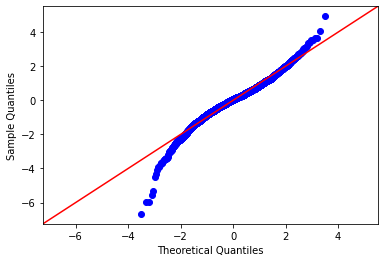

In [88]:
residuals7 = (y_test - pred_lr7)
sm.graphics.qqplot(residuals7, dist=stats.norm, line="45", fit=True);

Text(0, 0.5, 'Actual - Predicted Value')

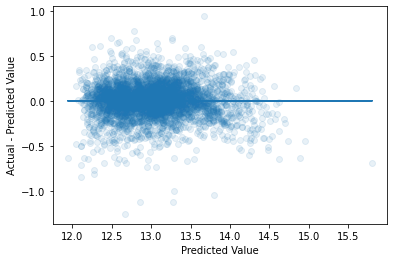

In [89]:
residuals7 = (y_test - pred_lr7)
fig, ax = plt.subplots()
ax.scatter(pred_lr7, residuals7, alpha=.1)
ax.plot(pred_lr7, [0 for i in range(len(X_test))])
ax.set_xlabel('Predicted Value')
ax.set_ylabel('Actual - Predicted Value')

<AxesSubplot:xlabel='price'>

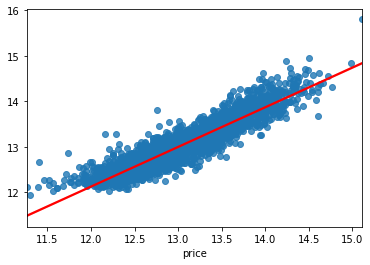

In [90]:
sns.regplot(x = y_test, y = pred_lr7, data = df, line_kws={'color':'r'})

### Model 8: A Polynomial model

In [91]:
df['grade_sqft_living'] = (df.grade**2) * df.sqft_living
df['grade_sqft_above'] = (df.grade**2) * df.sqft_above
df['grade_sqft_living15'] = (df.grade**2) * df.sqft_living15
df['grade_bathrooms'] = (df.grade**2) * df.bathrooms

In [92]:
X = df.drop(['price', 'sqft_basement', 'sqft_lot15', 'sqft_above', 'bathrooms', 'sqft_living', 'grade'], axis = 1)
y = df['price'] 
# y = np.log(y)

# ss = StandardScaler()
# X = ss.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [93]:
poly = PolynomialFeatures(2)

In [94]:
X_train_poly = poly.fit_transform(X_train)

In [95]:
X_test_poly = poly.transform(X_test)

In [96]:
lr = LinearRegression()

In [97]:
lr.fit(X_train_poly, y_train)

LinearRegression()

In [98]:
score_train_poly = lr.score(X_train_poly, y_train)

In [99]:
score_test_poly = lr.score(X_test_poly,y_test)

In [100]:
pred_poly = lr.predict(X_test_poly)

In [101]:
rmse_poly = mean_squared_error(y_test, pred_poly, squared=False)

In [102]:
score_train_poly, score_test_poly, rmse_poly #(0.9311304132469491, 0.8807643708530817, 128249.56887121135)

(0.919786743127535, 0.8869004825396294, 101637.651215152)

In [103]:
poly = PolynomialFeatures(2)
X_poly = poly.fit_transform(X_train)

model_1 = LinearRegression()

scores_simple = cross_validate(
                    model_1, X_poly, y_train, cv=5, 
                    return_train_score=True
)
scores_simple

{'fit_time': array([67.74944806, 66.69904423, 55.78828001, 62.0678761 , 61.66187501]),
 'score_time': array([0.13348413, 0.12817383, 0.1147368 , 0.10275698, 0.12912798]),
 'test_score': array([0.85454517, 0.85275239, 0.8653105 , 0.88266927, 0.87530347]),
 'train_score': array([0.92268068, 0.91775947, 0.92522076, 0.92220791, 0.92259912])}

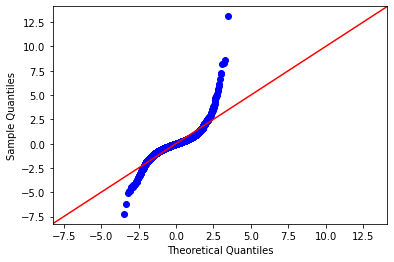

In [104]:
residuals = (y_test - pred_poly)
sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True);

In [105]:
residuals = (y_test - pred_lr)
fig, ax = plt.subplots()
ax.scatter(pred_lr, residuals, alpha=.1)
ax.plot(pred_lr, [0 for i in range(len(X_test))])
ax.set_xlabel('Predicted Value')
ax.set_ylabel('Actual - Predicted Value')

NameError: name 'pred_lr' is not defined

In [ ]:
sns.regplot(x = y_test, y = pred_poly, data = df, line_kws={'color':'r'})

In [ ]:
print("--- %s seconds ---" % (time.time() - start_time))